In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize, Bounds

In [2]:
def model(X,beta = None):
    if beta is None:
        beta = np.array([1.5,0.3,0.08,1,-0.6,3,-0.1,8,-1.3,1])
    return np.sin(np.dot(beta[0],X[:,0]))+np.power((beta[1]*X[:,1]),2) + (X[:,2]**2-beta[2]) + beta[3]*np.log(X[:,3]) + beta[4]*X[:,4]+ np.dot(beta[5],np.tan(X[:,5])) - (X[:,6]**3-(beta[6]*X[:,6]**2))+ np.power((beta[7]*np.sin(X[:,7])),1)-beta[8]*X[:,8]+beta[9]*np.sqrt((X[:,9]))

In [3]:
rng = np.random.RandomState(1)
X = rng.rand(1000, 10)
Y = model(X)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2) # Generating train and test dataset

In [4]:
#min_val_x = X.min()
#max_val_x = X.max()

min_val_y = Y.min()
max_val_y = Y.max()

#X_train = (X_train - min_val_x) / (max_val_x - min_val_x)
#X_test = (X_test - min_val_x) / (max_val_x - min_val_x)

#Y_train = (Y_train - min_val_y) / (max_val_y - min_val_y)
#Y_test = (Y_test - min_val_y) / (max_val_y - min_val_y)

Cobyla with co_des

In [5]:


class non_linear():
    def __init__(self,alpha,epochs = 1000,tol=1e-6):  
        self.alpha = alpha 
        self.epochs = epochs
        self.tol = tol
        self.coef_c = None   
        self.coef_l = None 
        self.coef_n = None 
    
    def loss(self,beta_j,X,Y,beta,j):  
        beta[j] = beta_j
        loss = (0.5/X.shape[0])* np.linalg.norm(Y- model(X,beta),ord=2)**2 + self.alpha* np.linalg.norm(beta,ord=1)
        return loss  

    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0  
    
    def fit(self,X,Y):         
        
        np.random.seed(123)
        beta_l =np.random.rand(X.shape[1]) #np.ones(X.shape[1])                      
        beta_n =np.random.rand(X.shape[1])
        beta_c =np.random.rand(X.shape[1])

        for iter in range(self.epochs): 
            beta_old_l = np.copy(beta_l)  
            beta_old_n = np.copy(beta_n)  
            beta_old_c = np.copy(beta_c)           
            
            for j in range(len(beta_l)):  

                options = {'maxiter': 1000000}                                      
                                            
                res_l = minimize(self.loss, x0=beta_l[j],args=(X,Y,beta_l,j), method='L-BFGS-B',jac = False, 
                               options=options,tol=1e-8)
                res_n = minimize(self.loss, x0=beta_n[j],args=(X,Y,beta_n,j), method='Nelder-Mead',jac = False, 
                               options=options,tol=1e-8)
                res_c = minimize(self.loss, x0=beta_c[j],args=(X,Y,beta_c,j), method='COBYLA',jac = False, 
                               options=options,tol=1e-8)
                                    
                beta_l[j] = (self.soft_threshold(res_l.x,1e-4))
                beta_n[j] = (self.soft_threshold(res_n.x,1e-4))
                beta_c[j] = (self.soft_threshold(res_c.x,1e-4))
                #print("Iterations: ", res.nfev)

            if np.linalg.norm(beta_l - beta_old_l) < self.tol:
                print("Optimization converged after l", iter+1, "iterations")
                break  
            if np.linalg.norm(beta_n - beta_old_n) < self.tol:
                print("Optimization converged after n", iter+1, "iterations")
                break 
            if np.linalg.norm(beta_c - beta_old_c) < self.tol:
                print("Optimization converged after c", iter+1, "iterations")
                break      
                
        self.coef_c = beta_c
        self.coef_l = beta_l
        self.coef_n = beta_n
            
        return self
    
    def predict(self, X):
        y_l = model(X,self.coef_l)
        y_n = model(X,self.coef_n)
        y_c = model(X,self.coef_c)
                
        return y_l,y_n,y_c
    
    def NRMSE(self,y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))

In [6]:
lamda = [0,0.0001,0.001,0.01,0.1,1,10]

In [7]:
test_loss = []
wo_c = np.zeros((len(lamda),X.shape[1]))
wo_l = np.zeros((len(lamda),X.shape[1]))
wo_n = np.zeros((len(lamda),X.shape[1]))

Nr_c = []
Nr_l = []
Nr_n = []

for i,val in enumerate(lamda):
    opt_cb = non_linear(val)
    opt_cb.fit(X_train,Y_train)    
    wo_c[i,:] = opt_cb.coef_c
    wo_l[i,:] = opt_cb.coef_l
    wo_n[i,:] = opt_cb.coef_n
    y_l,y_n,y_c = opt_cb.predict(X_test)
    #test_loss.append((tf.keras.losses.mae(yp, Y_test)).numpy())
    Nr_c.append(opt_cb.NRMSE(Y_test,y_c))
    Nr_l.append(opt_cb.NRMSE(Y_test,y_l))
    Nr_n.append(opt_cb.NRMSE(Y_test,y_n))

Optimization converged after l 140 iterations
Optimization converged after n 142 iterations
Optimization converged after n 138 iterations
Optimization converged after l 120 iterations
Optimization converged after l 106 iterations
Optimization converged after n 33 iterations
Optimization converged after l 2 iterations


In [8]:
print(Nr_c)
print(Nr_l)
print(Nr_n)

[0.0003216827513711373, 0.0010158069135230506, 0.011923912186909932, 0.035347465247044, 0.1825264425130286, 0.9874009961896244, 2.455098347336888]
[0.010429725921698545, 0.0010165096289310013, 0.011922508314274518, 0.03534457418608378, 0.1825272194758164, 0.9874009888941386, 2.455098347336888]
[0.00032176098580985257, 0.010498801555829464, 0.011923970577606077, 0.03534755178077249, 0.1825262920747886, 0.9874009466452074, 2.455098347336888]


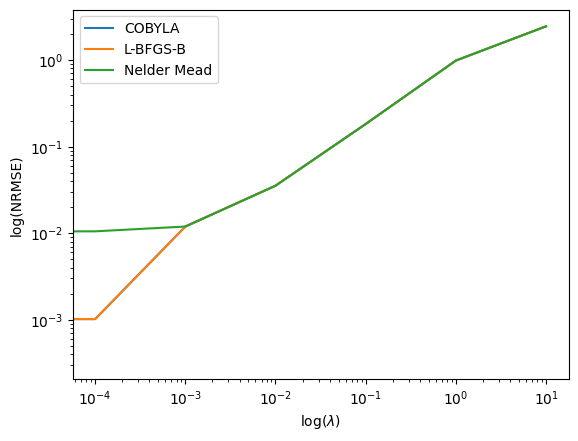

In [9]:
plt.plot(lamda,Nr_c,label='COBYLA')
plt.plot(lamda,Nr_l,label='L-BFGS-B')
plt.plot(lamda,Nr_n,label='Nelder Mead')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(NRMSE)')
plt.legend()
plt.show()

COBYLA without co and with epochs

In [10]:
np.random.seed(123)
class non_linear_all():
    def __init__(self,alpha,epochs = 1000):  
        self.alpha = alpha 
        self.epochs = epochs
        self.coef = None   
      
    def loss(self,beta,X,Y):       
        loss = (0.5/X.shape[0])* np.linalg.norm((Y- model(X,beta)),ord=2)**2 + self.alpha* np.linalg.norm(beta,ord=1)
        return loss  

    def soft_threshold(self,rho,lamda):
        if rho.all() < - lamda:
            return rho + lamda
        elif rho.all() > lamda:
            return rho - lamda
        else: 
            return 0  
    
    def fit(self,X,Y):         
        
        beta_l =np.random.rand(X.shape[1]) #np.ones(X.shape[1])                      
        beta_n =np.random.rand(X.shape[1])
        beta_c =np.random.rand(X.shape[1])  #np.ones(X.shape[1])                   

        options = {'maxiter': 100000,'disp':True}                                      
                                                            
        res_c = minimize(self.loss, x0=beta_c,args=(X,Y), method='COBYLA',jac = False, options=options,tol=1e-8)
        res_l = minimize(self.loss, x0=beta_l,args=(X,Y), method='L-BFGS-B',jac = False, options=options,tol=1e-8)
        res_n = minimize(self.loss, x0=beta_n,args=(X,Y), method='Nelder-Mead',jac = False, options=options,tol=1e-8)
                                                    
        beta_c = (self.soft_threshold(res_c.x,1e-5))
        beta_l = (self.soft_threshold(res_l.x,1e-5))
        beta_n = (self.soft_threshold(res_n.x,1e-5))
        print("Iterations c: ", res_c.nfev) 
        print("Iterations l: ", res_l.nfev)
        print("Iterations n: ", res_n.nfev)
            #print(beta)
                    
                
        self.coef_c = beta_c
        self.coef_l = beta_l
        self.coef_n = beta_n   
        return self
    
    def predict(self, X):
        y_c = model(X,self.coef_l)
        y_l = model(X,self.coef_n)
        y_n = model(X,self.coef_c)
                
        return y_l,y_n,y_c
    
    def NRMSE(self,y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))

In [11]:
test_loss_all = []
wo_c_all = np.zeros((len(lamda),X.shape[1]))
wo_l_all = np.zeros((len(lamda),X.shape[1]))
wo_n_all = np.zeros((len(lamda),X.shape[1]))
Nr_c_all = []
Nr_l_all = []
Nr_n_all = []

for i,val in enumerate(lamda):
    opt_cb = non_linear_all(val)
    opt_cb.fit(X_train,Y_train)    
    wo_c_all[i,:] = opt_cb.coef_c
    wo_l_all[i,:] = opt_cb.coef_l
    wo_n_all[i,:] = opt_cb.coef_n
    y_l_all,y_n_all,y_c_all = opt_cb.predict(X_test)
    #test_loss_all.append((tf.keras.losses.mae(yp_all, Y_test)).numpy())
    Nr_c_all.append(opt_cb.NRMSE(Y_test,y_c_all))
    Nr_l_all.append(opt_cb.NRMSE(Y_test,y_l_all))
    Nr_n_all.append(opt_cb.NRMSE(Y_test,y_n_all))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7039
         Function evaluations: 9835
Iterations c:  9074
Iterations l:  396
Iterations n:  9835
Optimization terminated successfully.
         Current function value: 0.002003
         Iterations: 3117
         Function evaluations: 4408
Iterations c:  9589
Iterations l:  396
Iterations n:  4408
Optimization terminated successfully.
         Current function value: 0.117584
         Iterations: 8609
         Function evaluations: 12152
Iterations c:  8888
Iterations l:  407
Iterations n:  12152
Optimization terminated successfully.
         Current function value: 0.229848
         Iterations: 4347
         Function evaluations: 6113
Iterations c:  913
Iterations l:  1155
Iterations n:  6113
Optimization terminated successfully.
         Current function value: 3.001708
         Iterations: 6418
         Function evaluations: 9081
Iterations c:  680
Iterations l:  1100
Iterations n:

In [12]:
print(Nr_c_all)
print(Nr_l_all)
print(Nr_n_all)

[4.1161087701064524e-05, 0.0007358562866437489, 0.0072635804639806425, 0.03565868950525156, 0.19707094278085435, 0.9061102636727264, 2.390864723329463]
[4.827419746195752e-06, 0.01045695717851851, 0.1620571202783392, 0.15190761219013732, 0.7205571487448699, 0.7826075408553648, 2.2405393413498924]
[4.8140929905072495e-06, 0.0007183266350568597, 0.0072557378093016855, 0.03948394947793855, 0.2536445407392423, 0.9499574963485958, 2.3921146841912395]


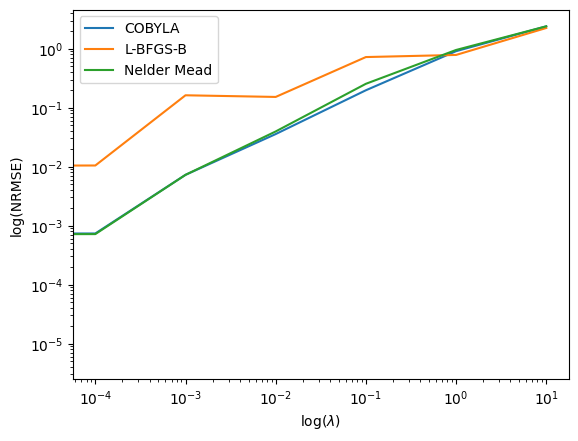

In [13]:
plt.plot(lamda,Nr_c_all,label='COBYLA')
plt.plot(lamda,Nr_l_all,label='L-BFGS-B')
plt.plot(lamda,Nr_n_all,label='Nelder Mead')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(NRMSE)')
plt.legend()
plt.show()

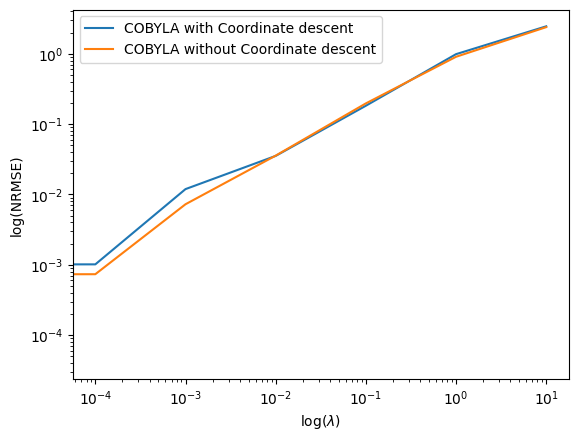

In [14]:
plt.plot(lamda,Nr_c,label='COBYLA with Coordinate descent')
plt.plot(lamda,Nr_c_all,label='COBYLA without Coordinate descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(NRMSE)')
plt.legend()
plt.show()

Gradient Descent

In [15]:
def model_tf(X,beta):
    X  = tf.cast(X, dtype='float32')
    return tf.sin(beta[0] *X[:, 0]) + tf.pow((beta[1] * X[:, 1]), 2) + \
           (tf.pow(X[:, 2], 2) - beta[2]) + beta[3] * tf.math.log(X[:, 3]) + \
           beta[4] * X[:, 4] + (beta[5] *tf.math.tan(X[:, 5])) - \
           (tf.pow(X[:, 6], 3) - (beta[6] * tf.pow(X[:, 6], 2))) + \
           tf.pow((beta[7] * tf.sin(X[:, 7])), 1) - beta[8] * X[:, 8] + \
           beta[9] * tf.math.sqrt(X[:, 9])

In [21]:
init_slope = np.ones(5)

def run_gradient_descent(X, Y,learning_rate,lam ,epochs = 10000):
   init_slope = np.ones(X.shape[1])
   tf_slope = tf.Variable(init_slope, dtype='float32') 

   def soft_threshold(rho,lamda):
        rho_np = rho.numpy()
        if np.all(rho_np < -lamda):
            return rho + lamda
        elif np.all(rho_np > lamda):
            return rho - lamda
        else:
            return tf.zeros_like(rho)

   for i in range(epochs):
        with tf.GradientTape() as tape:
            tape.watch(tf_slope)

            # This is the same mean-squared-error calculation as before
            #X_r  = tf.cast(X, dtype='float32')
            #pred = tf.cast (model(X_float32,tf_slope),dtype= 'float32')
            Y_reshaped = tf.cast(tf.reshape(Y, (-1, 1)), dtype='float32')         
            
            loss = (0.5 / X.shape[0]) * tf.norm((tf.transpose(Y_reshaped)- model_tf(X,tf_slope)),ord=2)**2 + lam * tf.norm(tf_slope, ord=1)        
            

        # Auto-diff magic!  Calcs gradients between loss calc and params
        dloss_dparams = tape.gradient(loss, tf_slope)        
        # Gradients point towards +loss, so subtract to "descend"
        tf_slope.assign_sub(learning_rate * dloss_dparams)
        #tf_slope.assign(soft_threshold(tf_slope, 1e-3))
        #print(tf_slope)
        
        
   return tf_slope

def NRMSE(y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))

In [22]:
Nr_gd = []
for i in lamda:
    wo_gd = (run_gradient_descent(X_train, Y_train, 0.1,i,epochs=3000))    
    print(wo_gd)
    yp_gd = model_tf(X_test,wo_gd)
    Nr_gd.append((NRMSE(Y_test,yp_gd)))

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([ 1.488421  ,  0.29941976,  0.07547453,  0.9999918 , -0.60042375,
        2.9997818 , -0.10018981,  7.9995885 , -1.2994502 ,  0.9992137 ],
      dtype=float32)>
<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([ 1.4783823 ,  0.29546273,  0.0681564 ,  0.99995506, -0.5997544 ,
        2.9990442 , -0.09953324,  7.9972253 , -1.297344  ,  0.99654454],
      dtype=float32)>
<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([ 1.3925900e+00,  2.5009897e-01,  1.5064760e-03,  9.9955773e-01,
       -5.9361595e-01,  2.9926357e+00, -9.3405232e-02,  7.9758406e+00,
       -1.2782599e+00,  9.7282624e-01], dtype=float32)>
<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([ 1.11419439e+00,  0.00000000e+00, -3.21471617e-02,  9.78384316e-01,
       -4.17121977e-01,  2.98638034e+00, -1.04074774e-04,  7.90937090e+00,
       -1.22160614e+00,  9.55300748e-01], dtype=float32)>
<tf.Variable 'Variab

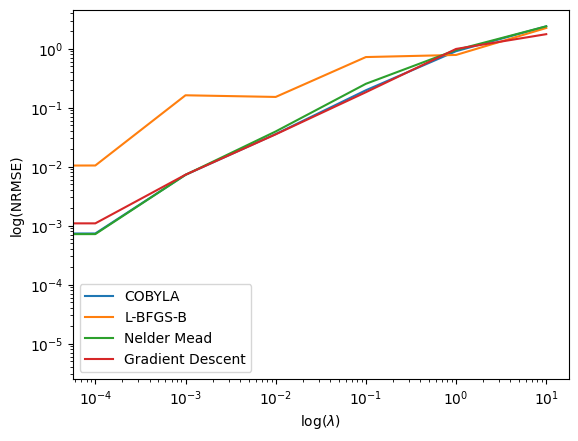

In [24]:
plt.plot(lamda,Nr_c_all,label='COBYLA')
plt.plot(lamda,Nr_l_all,label='L-BFGS-B')
plt.plot(lamda,Nr_n_all,label='Nelder Mead')
plt.plot(lamda,Nr_gd,label='Gradient Descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(NRMSE)')
plt.legend()
plt.show()